In [21]:
!pip install statsmodels

# Predict model performance

In [22]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [23]:
DATA_PATH = 'data/aggregated/experiments.csv'

Data

In [24]:
df = pd.read_csv(DATA_PATH)
df.head(5)

,topology,cells_number,possible_moves,connection_degree,depth,mean_log2_max_tile
0,hex,19,6,4.421053,1,11.105
1,hex,19,6,4.421053,4,13.065
2,hex,19,6,4.421053,2,11.275
3,hex,19,6,4.421053,3,13.130
4,hex,19,6,4.421053,0,9.120


Model training

In [25]:
features = ['cells_number', 'possible_moves', 'connection_degree', 'depth']
X = df[features].values
y = df['mean_log2_max_tile'].values

In [26]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

Evaluating

In [27]:
X_pred = sm.add_constant(X)
y_pred = model.predict(X_pred)

In [28]:
df['predicted_mean_log2_max_tile'] = y_pred
df_comparison = df[['depth', 'cells_number', 'possible_moves', 'connection_degree', 'mean_log2_max_tile', 'predicted_mean_log2_max_tile']]

Understanding the model

In [29]:
summary_df = pd.DataFrame({
    "feature": ["intercept", "cells_number", "possible_moves", "connection_degree", "depth"],
    "coef": model.params,
    "std_error": model.bse,
    "p_value": model.pvalues
})
summary_df

,feature,coef,std_error,p_value
0,intercept,-2.751540,0.791991,0.005201
1,cells_number,0.266061,0.037939,0.000022
2,possible_moves,-0.194792,0.173183,0.284630
3,connection_degree,1.988246,0.506589,0.002373
4,depth,0.807000,0.105598,0.000010


Comparing predicted performance across different depths











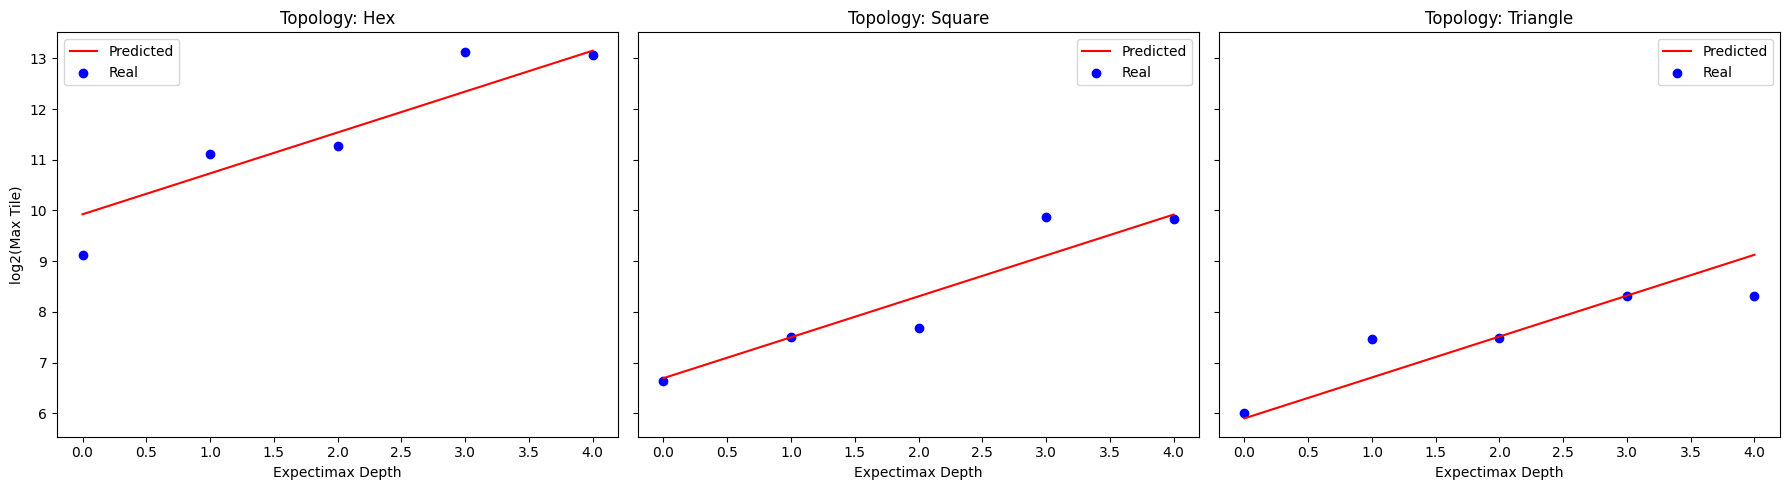

In [30]:
topologies = df["topology"].unique()
n_topos = len(topologies)

fig, axes = plt.subplots(nrows=1, ncols=n_topos, figsize=(6 * n_topos, 5), sharey=True)

if n_topos == 1:
    axes = [axes]

for ax, topo in zip(axes, topologies):
    topo_df = df[df["topology"] == topo].sort_values("depth")
    
    ax.plot(
        topo_df["depth"],
        topo_df["predicted_mean_log2_max_tile"],
        color='red',
        linestyle='-',
        label="Predicted"
    )

    ax.scatter(
        topo_df["depth"],
        topo_df["mean_log2_max_tile"],
        color='blue',
        marker='o',
        label="Real"
    )
    
    ax.set_title(f"Topology: {topo.capitalize()}")
    ax.set_xlabel("Expectimax Depth")
    ax.legend()

axes[0].set_ylabel("log2(Max Tile)")

plt.tight_layout()
plt.show()